In [4]:
import os 
import numpy as np
import torch
from PIL import Image
from tqdm.auto import tqdm

In [5]:
# read sh variable 
with open('/pure/tu150/datasets/relight/face/ffhq/ffhq-train-light-anno.txt')as f:
    sh_raw = f.readlines()

with open('/pure/tu150/datasets/relight/face/ffhq/ffhq-valid-light-anno.txt')as f:
    sh_raw += f.readlines()

In [6]:
sh_dict = {}
for line in tqdm(sh_raw):
    line = line.strip()
    components = line.split(' ')
    name = int(components[0].split('.')[0])
    sh = np.array([float(x) for x in components[1:]])
    #sh = torch.tensor(sh).reshape(9, 3)
    #sh = sh.numpy()
    sh = sh.reshape(9, 3)
    sh_dict[name] = sh

  0%|          | 0/70000 [00:00<?, ?it/s]

In [7]:
sh_list = []
for key in range(70000):
    sh_list.append(sh_dict[key])

In [9]:
sh_list = np.array(sh_list)
# convert to gray scael
sh_grays = sh_list[:, :, 0] * 0.299 + sh_list[:, :, 1] * 0.587 + sh_list[:, :, 2] * 0.114

In [11]:
def applySHlight(normal_images, sh_coeff):
  N = normal_images
  sh = torch.stack(
    [
      N[0] * 0.0 + 1.0,
      N[0],
      N[1],
      N[2],
      N[0] * N[1],
      N[0] * N[2],
      N[1] * N[2],
      N[0] ** 2 - N[1] ** 2,
      3 * (N[2] ** 2) - 1,
    ],
    0,
  )  # [9, h, w]
  pi = np.pi
  constant_factor = torch.tensor(
    [
      1 / np.sqrt(4 * pi), #confirmed
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
    ]
  ).float()
  sh = sh * constant_factor[:, None, None]

  shading = torch.sum(
    sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
  )  # [9, 3, h, w]

  return shading

def genSurfaceNormals(n):
  x = torch.linspace(-1, 1, n)
  y = torch.linspace(1, -1, n)
  y, x = torch.meshgrid(y, x)

  z = (1 - x ** 2 - y ** 2)
  mask = z < 0
  z[mask] = 0
  z = torch.sqrt(z)
  return torch.stack([x, y, z], 0), mask

def applySHlightXYZ(xyz, sh):
  out = applySHlight(xyz, sh)
  return out 

def drawSphere(sh, img_size=256, is_back=False, white_bg=False):
  n = img_size
  xyz, mask = genSurfaceNormals(n)
  if(is_back):
    xyz[2] = xyz[2] * -1
  if white_bg:
    xyz[:, mask] = 1
  out = applySHlightXYZ(xyz, sh)
  out[:, xyz[2] == 0] = 0
  return out


In [12]:
def process_sh(sh_coeff):
    sh_viz = drawSphere(torch.tensor(sh_coeff)).permute(1,2,0).numpy()
    sh_gray = 0.299*sh_viz[..., 0]  + 0.587*sh_viz[..., 1] + 0.114*sh_viz[..., 2]
    highest_position = np.unravel_index(np.argmax(sh_gray), sh_gray.shape)
    return highest_position

In [13]:
positions = []
for sh in tqdm(sh_list[:20000]):
    positions.append(process_sh(sh))

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/vll/venv_pytorch2.0/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
positions = np.array(positions)

In [20]:
top_10_indices = np.argsort(positions[:20000,0])[-10:]


[ 4871  8256 10735  2829 16431 14942 19998  6776 15547   346]
ID:  4871


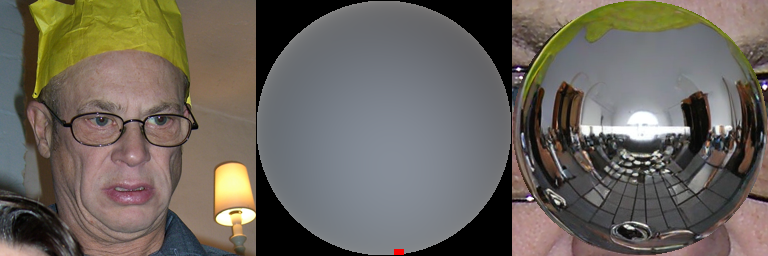

ID:  8256


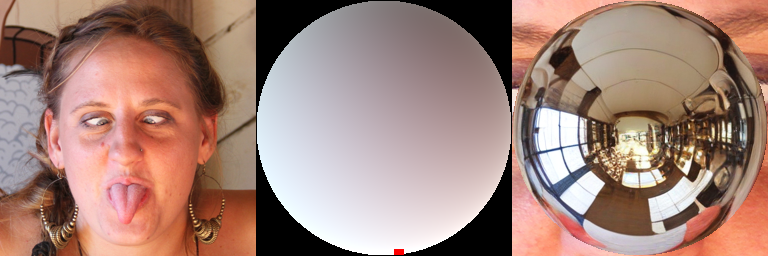

ID:  10735


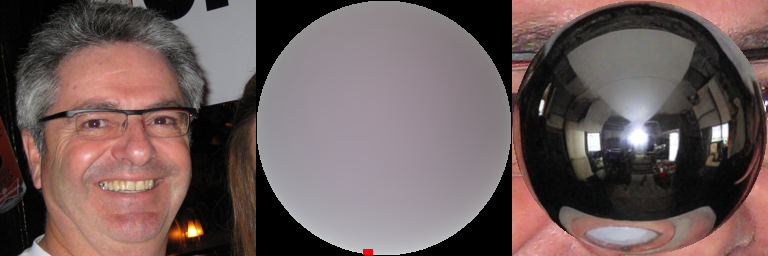

ID:  2829


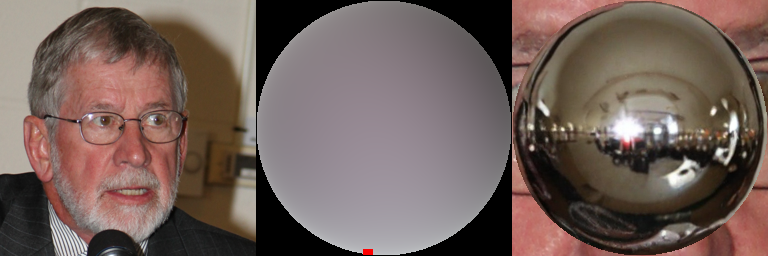

ID:  16431


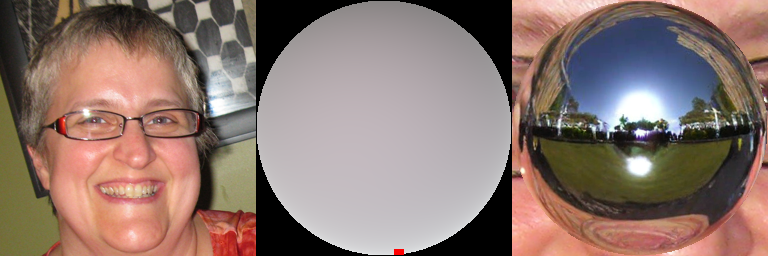

ID:  14942


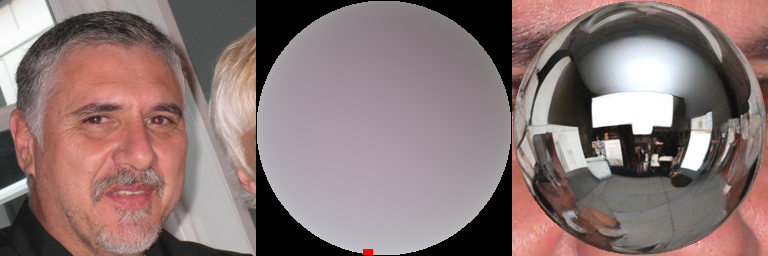

ID:  19998


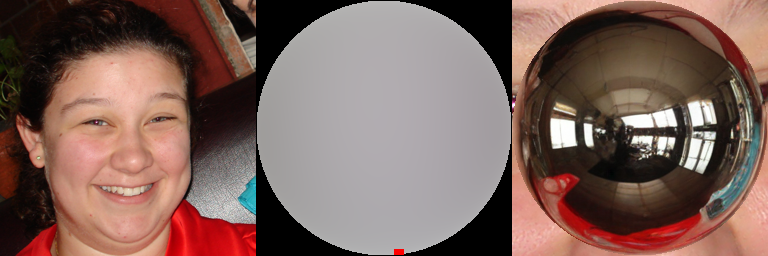

ID:  6776


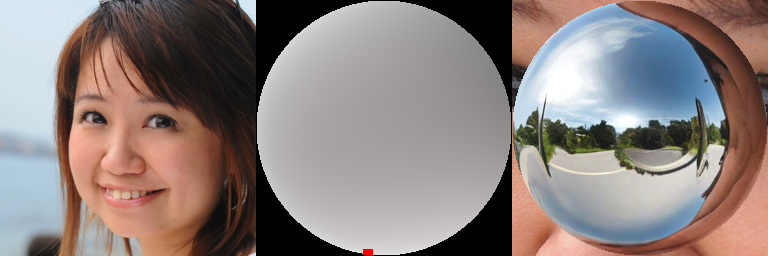

ID:  15547


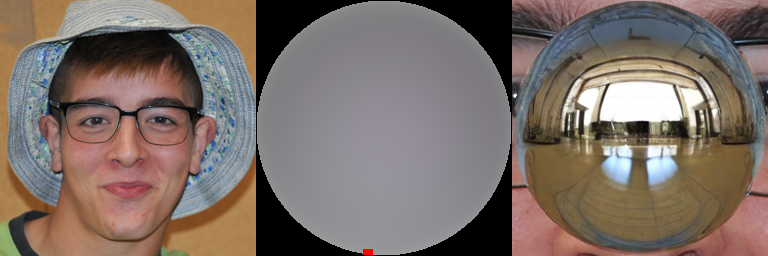

ID:  346


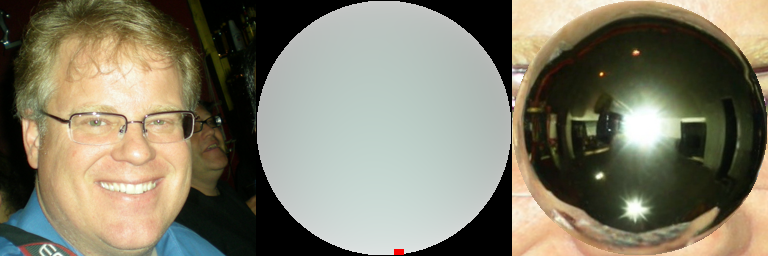

In [21]:
# look into y axis 
print(top_10_indices)
for i in top_10_indices:
    print("ID: ", i)
    #sphere = drawSphere(torch.tensor(sh_list[i]))
    # convert sphere from torch tensor to PIL image and display
    #sphere = Image.fromarray((sphere.permute(1,2,0).numpy() * 255.0).astype(np.uint8))
    sphere = Image.open(f'../../datasets/face/face70000/ball/{i // 1000 * 1000:05d}/{i:05d}.png').resize((256, 256))
    # get source image 
    source = Image.open(f'/pure/tu150/datasets/relight/face/ffhq/images/{i // 1000 * 1000:05d}/{i:05d}.png').resize((256, 256))
    # get ball image
    ball = Image.open(f'/pure/tu150/datasets/relight/face/ffhq/diffusionlight/{i // 1000 * 1000:05d}/square/{i:05d}_ev-00.png').resize((256, 256))    

    # merge source and sphere and ball into one image
    merged = Image.new('RGB', (768, 256))
    merged.paste(source, (0, 0))
    merged.paste(sphere, (256, 0))
    merged.paste(ball, (512, 0))
    display(merged)

